In [ ]:
# @title 1. Setup & Load (Stable)
!pip install -q diffusers transformers accelerate safetensors openai pydantic rembg onnxruntime-gpu imageio[ffmpeg]
!pip install --upgrade openai pydantic

import torch
import gc
import os
import getpass
import numpy as np
import math
import time
from diffusers import AutoPipelineForImage2Image
from PIL import Image
from IPython.display import display
from rembg import remove, new_session
from typing import List, Dict, Literal, Optional
from pydantic import BaseModel, Field, field_validator
from openai import OpenAI
import re
import json
from IPython.display import display

# --- 🛠️ MEMORY SETTING: Fragmentation Handling ---
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Setup OpenAI client
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key: ")
client = OpenAI()

# Clean up
if 'pipe' in globals(): del pipe
gc.collect()
torch.cuda.empty_cache()

print("⏳ Loading SDXL-Turbo (FP16)...")
pipe = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16,
    variant="fp16",
    low_cpu_mem_usage=True
).to("cuda")

# Aggressive memory saving settings
pipe.enable_vae_slicing()
pipe.enable_vae_tiling()

print("✅ System Ready.")

⏳ Loading SDXL-Turbo (FP16)...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ System Ready.


In [12]:
# @title 2. Generator (Resolution Safe)
import torch.nn as nn
import torch

def generate_dream_scene(prompt_a, prompt_b=None, type="pano", frames=4):
    # Clear memory before starting
    torch.cuda.empty_cache()

    # --- 1. SEAMLESS HACK ---
    def make_seamless(model):
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                m.padding_mode = 'circular' if type == "pano" else 'zeros'
        return model

    pipe.unet = make_seamless(pipe.unet)
    pipe.vae = make_seamless(pipe.vae)

    # --- 2. CONFIG (MEMORY SAFE) ---
    if type == "pano":
        # 768x384 is safe for T4 GPUs
        width, height = 768, 384
        neg = "tilted, crooked, off-center, floor view, aerial, objects, items, spheres"
    else:
        # 320x320 is standard for SDXL-Turbo sprites
        width, height = 320, 320
        neg = "background, ground, shadow, tree, wall, floor, static, plain white"

    style_header = "Ink and watercolor, thick india ink lines, vintage paper texture, hazy, sepia"
    generated_images = []

    current_image = Image.new("RGB", (width, height), (255, 255, 255))

    # --- 3. GENERATION LOOP ---
    with torch.no_grad(): # Critical: Disables gradients to save VRAM
        for i in range(frames):
            target_prompt = prompt_b if prompt_b else prompt_a

            if type == "pano":
                current_raw = prompt_a
                strength = 1.0 if i == 0 else 0.4
            else:
                if i == 0: current_raw, strength = prompt_a, 1.0
                elif i == 1: current_raw, strength = prompt_a, 0.5
                elif i == 2: current_raw, strength = target_prompt, 0.6
                else: current_raw, strength = target_prompt, 0.5

            safe_text = " ".join(current_raw.split()[:20])
            full_prompt = f"{style_header}, {safe_text}, {'360 panorama' if type=='pano' else 'isolated cutout'}"

            image = pipe(
                prompt=full_prompt,
                negative_prompt=neg,
                image=current_image,
                num_inference_steps=4,
                strength=strength,
                guidance_scale=0.0,
                width=width, height=height
            ).images[0]

            generated_images.append(image)
            current_image = image

    # --- 4. POST-PROCESS (CPU ONLY) ---
    if type == "sprite":
        # Force background removal on CPU
        session = new_session("u2net", providers=['CPUExecutionProvider'])
        final_images = []
        for img in generated_images:
            clean_img = remove(img, session=session)
            final_img = Image.new("RGBA", clean_img.size, (0, 0, 0, 0))
            final_img.paste(clean_img, (0, 0), clean_img)
            final_images.append(final_img)
        return final_images

    return generated_images

In [21]:
# @title 3. The Dream Scryer (Entity-Specific Actions)
from typing import List, Literal, Optional, Dict, Any
from pydantic import BaseModel, Field, field_validator # We still need field_validator for emotion
from openai import OpenAI
import os
import getpass
import re

# --- CONSTANTS ---
VALID_TIMES = Literal["Day", "Night", "Between"]
VALID_CONDITIONS = Literal["Peaceful", "Chaotic"]
CORE_EMOTIONS = ["Neutral", "Joy", "Sorrow", "Anger", "Fear"]
# CORE_ACTIONS is now just for guiding the LLM's imagination.

# Setup OpenAI client
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key: ")
client = OpenAI()

# --- SYSTEM PROMPT (UPDATED) ---
SYSTEM_PROMPT = """
You are the Dream Architect. Simulate a living dream world defined by a Hex (7 Stations).

### 1. WORLD STATE (World and Background Prompts)

### 2. ENTITY DEFINITION
- **For EACH entity:**
  - **CURRENT STATE:** 'current_emotion' (Neutral/Joy/Sorrow/Anger/Fear). 'current_action' must be a single, appropriate verb/gerund for the entity (e.g., 'Meditate', 'Purr', 'Pace').
  - **BASE NOUN:** (MAX 4 WORDS) The subject. Strict Noun Phrase.
  - **ENTITY ACTIONS (NEW):** Provide 5 unique, appropriate actions for this entity (e.g., 'Meditate', 'Purr', 'Gaze', 'Hiss', 'Run').
  - **ASSET FRAGMENTS:** Provide Modifiers & Verbs (Max 2-4 words) for the 5 Emotions and the 5 unique Actions.
  - **Written Description:** Multi-sentence narrative.

### 3. RELATIONAL MATRIX (Greetings & Options)

### OUTPUT
Return strictly structured JSON.
"""

RECALC_PROMPT = """
The User (Active Station) performed an ACTION on Target Station.
1. Update World State. 2. Update Emotion/Action. 3. Update Dialog. 4. Provide 3 NEW options.
"""

# --- DATA MODELS ---

class GeneratedAsset(BaseModel):
    file_paths: List[str]
    full_prompt: str

class Relationship(BaseModel):
    target_id: str
    greeting_dialogue: str
    interaction_options: List[str] = Field(..., min_length=3, max_length=3)

class EntityActionPrompt(BaseModel):
    name: str = Field(..., description="The unique name of the action (e.g., Meditate, Purr).")
    prompt_modifier: str = Field(..., description="Max 4 words. The visual verb/gerund for this action.")

class VisualPrompts(BaseModel):
    neutral: str = Field(..., description="Max 2 words. Adjectives.")
    joy: str
    sorrow: str
    anger: str
    fear: str
    # Removed fixed action fields. We now use a list of dynamic action objects below.

class _WorldStateGenerated(BaseModel):
    time: Literal["Day", "Night", "Between"]
    condition: Literal["Peaceful", "Chaotic"]
    music_track_id: str
    base_noun: str = Field(..., description="Max 4 words. The setting.")
    mood_modifier: str = Field(..., description="Max 2 words. Lighting/Mood.")
    ambient_verb: str = Field(..., description="Max 4 words. Ambient motion.")
    written_description: str = Field(..., description="Multi-sentence narrative for game copy.")

class _StationGenerated(BaseModel):
    id: str
    entity_name: str
    position_index: int
    is_player: bool = False

    current_emotion: str = Field(..., description="One of: Neutral, Joy, Sorrow, Anger, Fear")
    current_action: str = Field(..., description="Must be one of the entity's 5 unique actions (e.g., Meditate, Purr).")

    relationships: List[Relationship]
    base_noun: str = Field(..., description="Max 4 words. Noun Phrase. No verbs.")
    visual_summary: str = Field(..., description="Full prose description for context.")

    # 1. NEW FIELD: Store the 5 unique actions
    entity_actions: List[str] = Field(..., min_length=5, max_length=5, description="5 unique, appropriate actions for this entity.")

    # 2. UPDATED FIELD: Store the 5 unique action prompts in a list of objects
    asset_emotion_prompts: VisualPrompts
    asset_action_prompts: List[EntityActionPrompt] = Field(..., min_length=5, max_length=5, description="5 unique action prompts corresponding to entity_actions.")

    written_description: str = Field(..., description="Multi-sentence narrative for game copy.")

# --- DATA MODELS: FINAL STORAGE CLASSES (Used by the Game Engine/Manifest) ---

class WorldState(BaseModel):
    time: Literal["Day", "Night", "Between"]
    condition: Literal["Peaceful", "Chaotic"]
    music_track_id: str
    base_noun: str
    mood_modifier: str
    ambient_verb: str
    generated_asset: Optional[GeneratedAsset] = None
    written_description: str

class Station(BaseModel):
    id: str
    entity_name: str
    position_index: int
    is_player: bool = False
    current_emotion: str
    current_action: str
    relationships: List[Relationship]
    base_noun: str
    visual_summary: str

    # Storage Fields
    generated_assets: Dict[str, GeneratedAsset] = Field(default_factory=dict)
    written_description: str

    # 👇 NEW FIELD for storage
    entity_actions: List[str]
    asset_emotion_prompts: VisualPrompts
    asset_action_prompts: List[EntityActionPrompt]

    @field_validator('current_emotion')
    @classmethod
    def validate_emotion(cls, v):
        v_upper = v.capitalize()
        if v_upper not in CORE_EMOTIONS: raise ValueError(f"Emotion '{v}' is not a valid key.")
        return v_upper

    # 💥 CRITICAL FIX: REMOVED current_action validator
    # The validation is now handled by the LLM following the SYSTEM_PROMPT.


class _DreamHexGenerated(BaseModel):
    title: str
    slug: str
    world_state: _WorldStateGenerated
    stations: List[_StationGenerated]

class RecalculationResponse(BaseModel):
    new_world_state: _WorldStateGenerated
    updated_stations: List[_StationGenerated]

# --- FUNCTIONS ---

def analyze_dream(dream_text):
    print(f"🔮 Architecting Dream World...")
    try:
        completion = client.beta.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": f"Dream Text: {dream_text}"}
            ],
            response_format=_DreamHexGenerated,
        )
        data = completion.choices[0].message.parsed
        data.slug = re.sub(r'[^a-z0-9-]', '', data.slug.lower())

        # CRUCIAL STEP: Convert the simple output back into the complex storage schema
        final_world_state = WorldState(**data.world_state.model_dump())
        final_stations = [Station(**s.model_dump()) for s in data.stations]

        return {
            'world_state': final_world_state,
            'stations': final_stations,
            'title': data.title,
            'slug': data.slug
        }

    except Exception as e:
        print(f"❌ Analysis Error: {e}")
        return None

def recalculate_dream_state(current_hex, active_station_id, target_station_id, action_taken):
    print(f"⚡ Recalculating: {active_station_id} -> {action_taken} -> {target_station_id}")
    query = f"World: {current_hex.world_state.time}. Active: {active_station_id}. Target: {target_station_id}. Action: {action_taken}."
    try:
        completion = client.beta.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[{"role": "system", "content": RECALC_PROMPT}, {"role": "user", "content": query}],
            response_format=RecalculationResponse,
        )
        return completion.choices[0].message.parsed
    except Exception as e:
        print(f"❌ Recalc Error: {e}")
        return None

🏭 Starting World Builder...

🔮 DREAM 1...
🔮 Architecting Dream World...
🎨 BG: Neon Rain Forest...


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

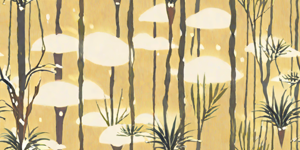

🧚 Generating Entities...
   👤 Cyber-Jaguar...


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   👤 Circuit Monk...


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]


📦 Zipping...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# @title 4. World Builder (Action Lookup Logic)
import shutil
import os
import time
from IPython.display import display
from google.colab import files
import gc
import torch

# --- SETTINGS ---
GENERATE_FULL_MATRIX = False
CHAPTER_1_TEXT = """
I stood in a neon-lit rain forest. It was Night and Chaotic.
A Cyber-Jaguar paced nervously on a branch.
A Monk made of circuitry sat in meditation, ignoring the rain.
"""
BATCH_INPUT = [CHAPTER_1_TEXT]
CORE_EMOTIONS = ["Neutral", "Joy", "Sorrow", "Anger", "Fear"] # CORE_ACTIONS is not needed here now

# --- HELPERS ---
def normalize_llm_keyword(key_word: str, target_list: List[str]) -> str:
    """Aggressively converts LLM output to match Python attribute keys, but now only for EMOTIONS."""
    # Since Actions are custom, this is primarily used for Emotions
    key_word = key_word.lower()

    if key_word.capitalize() in target_list: return key_word

    # Generic normalization for safety
    normalized = key_word.rstrip('s').rstrip('ing').rstrip('g').rstrip('in')
    if normalized == 'teract': normalized = 'interact'

    if normalized.capitalize() in target_list: return normalized.lower()

    # Fallback for dynamic fields, though this should mostly be used for EMOTIONS now
    return key_word.lower()

def save_frame_sequence(image_list, folder_path, file_prefix, file_format="PNG"):
    saved_paths = []
    for i, img in enumerate(image_list):
        filename = f"{file_prefix}_{i}.{file_format.lower()}"
        full_path = os.path.join(folder_path, filename)
        if file_format == "JPEG": img.convert("RGB").save(full_path, quality=85)
        else: img.save(full_path, format="PNG")
        saved_paths.append(os.path.join(os.path.basename(folder_path), filename))
    return saved_paths

# --- RUNNER ---
def run_world_builder():
    base_dir = "dream_hex_build"
    assets_dir = os.path.join(base_dir, "assets")
    if os.path.exists(base_dir): shutil.rmtree(base_dir)
    os.makedirs(assets_dir)

    manifest = {"version": "3.1", "dreams": []}
    print(f"🏭 Starting World Builder...")

    for i, text in enumerate(BATCH_INPUT):

        # 1. ANALYSIS & SETUP
        gc.collect()
        torch.cuda.empty_cache()

        print(f"\n{'='*30}\n🔮 DREAM {i+1}...")
        hex_data_dict = analyze_dream(text) # Returns a dictionary of Pydantic objects

        if not hex_data_dict: continue

        # Unpack dictionary to access data
        hex_data = hex_data_dict['world_state']
        stations = hex_data_dict['stations']
        slug = hex_data_dict['slug']

        dream_folder = os.path.join(assets_dir, slug)
        os.makedirs(dream_folder, exist_ok=True)

        # 2. BACKGROUND CONSTRUCTION
        print(f"🎨 BG: {hex_data.base_noun[:30]}...")
        bg_prompt = f"{hex_data.base_noun}, {hex_data.mood_modifier}, {hex_data.ambient_verb}"

        bg_frames = generate_dream_scene(bg_prompt, type="pano", frames=3)
        display(bg_frames[0].resize((300, 150)))

        bg_paths = save_frame_sequence(bg_frames, dream_folder, f"{slug}_bg", "JPEG")

        hex_data.generated_asset = GeneratedAsset(file_paths=bg_paths, full_prompt=bg_prompt)

        # 3. ENTITY GENERATION
        print(f"🧚 Generating Entities...")
        for station in stations:
            print(f"   👤 {station.entity_name}...")

            def generate_asset(modifier_prompt, action_verb, key_name):
                full_prompt = f"{station.base_noun}, {modifier_prompt}, {action_verb}"

                frames = generate_dream_scene(full_prompt, type="sprite", frames=4)
                prefix = f"{slug}_{station.id}_{key_name}"
                paths = save_frame_sequence(frames, dream_folder, prefix, "PNG")

                return GeneratedAsset(file_paths=paths, full_prompt=full_prompt)

            # --- DYNAMIC ACTION LOOKUP ---
            c_emo = station.current_emotion
            c_action_name = station.current_action # The LLM's custom action name (e.g., 'Meditate')

            # 1. Get Emotion Modifier (still uses explicit field access)
            emo_mod = getattr(station.asset_emotion_prompts, c_emo.lower())

            # 2. Get Action Verb Modifier (Must search the list of objects for the correct action name)
            action_prompt_verb = None
            for action_obj in station.asset_action_prompts:
                if action_obj.name.capitalize() == c_action_name.capitalize():
                    action_prompt_verb = action_obj.prompt_modifier
                    break

            if not action_prompt_verb:
                print(f"⚠️ ERROR: Could not find prompt for action '{c_action_name}'. Skipping asset generation.")
                continue

            # 3. Generate and Store
            key = f"{c_emo.lower()}_{c_action_name.lower().replace(' ', '_')}"

            generated_asset_obj = generate_asset(emo_mod, action_prompt_verb, key)
            station.generated_assets[key] = generated_asset_obj

            gc.collect()
            torch.cuda.empty_cache()

        # 4. FINAL MANIFEST EXPORT
        final_manifest_entry = {
            'title': hex_data_dict['title'],
            'slug': hex_data_dict['slug'],
            'world_state': hex_data.model_dump(),
            'stations': [s.model_dump() for s in stations]
        }
        manifest["dreams"].append(final_manifest_entry)

    # Final Save
    with open(os.path.join(base_dir, "world.json"), "w") as f:
        json.dump(manifest, f, indent=2)

    print("\n📦 Zipping...")
    shutil.make_archive("dreamhex_world", 'zip', base_dir)
    files.download("dreamhex_world.zip")

run_world_builder()